In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.sim_drifter as sdr

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(2*28)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [5]:
client

Client Scheduler: tcp://10.148.1.70:59999 Dashboard: http://10.148.1.70:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [6]:
#root_path = '/home1/scratch/aponte/'
root_path = '/home/c11-data/Test_aponte/jetn/'
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

In [7]:
#r = pp.Run(root_path+run, prefix='file_', open_nc=['surf'], verbose=True)
r = pp.Run(root_path+run, open_nc=['surf'], tdir_max=1, verbose=True)
r['surf'] = r['surf'].rename({'time_instant': 'time'})

Analysing directory /home/c11-data/Test_aponte/jetn/jet_cfg1_wp75_4km_1500a2000j_itide/
Found 1 segments
Found 1 grid files
Found 2 surf files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['grid', 'surf']
Grid size: (L ,M, N) = (258, 722, 50)


In [8]:
dr = sdr.drifter_dataframe(root_path+run, tdir_max=1)

In [9]:
df0 = dr.df.groupby('time').get_group(1557.5).compute().sort_values('id').set_index('id')

In [10]:
lats = [725,1215,1515,1715,2100]
df0['id'] = df0.index
df0 = df0.sort_values('y').set_index('y')

In [ ]:
df0.iloc[4530:4580]

In [12]:
t0 = 1550
t1 = 1565
tmid = (t0+t1)/2
flt_id = 119

In [13]:
V = ['u', 'v']
dij = 5
dti = 1
ds = (r['surf'][V].isel({'x_rho': slice(0,None,dij), 'x_u': slice(0,None,dij),
                         'y_rho': slice(0,None,dij), 'y_v': slice(0,None,dij),
                         'time': slice(0,None,dti)})
     ).squeeze()
print('dataset size: %.0f GB' %(ds.nbytes/1e9))

dataset size: 1 GB


In [7]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=['surf'], 
                chunk_time={'his': 1, 'surf': 1}, grid_params=gparams)

ds = r['surf']#.assign_coords(time=ds.time_counter)

dxy = 4
dsi = ds.assign_coords(time=ds.time_counter).sel(time=slice(1500,1600)).isel(s_rho_slice0=0)
dsi = dsi.assign_coords(x_rho=dsi.x_rho*dxy,y_rho=dsi.y_rho*dxy,x_u=dsi.x_u*dxy,y_v=dsi.y_v*dxy)

In [14]:
flt1 = dr.df.groupby('id').get_group(flt_id).compute().sort_values('time').set_index('time')

In [15]:
# Informations on drifter trajectory:
flti = flt1.loc[t0:t1]
latmin,latmax, latmid = flti.y.min(),flti.y.max(), flt1.loc[tmid].y
 
#_p = flt1.loc[t:t+T]
# compute average position
#x, y = sdr.mean_position(_p, L)

In [16]:
print('Minimum latitude : ',latmin,';  Maximum latitude : ',latmax,';  Latitude at tmid : ',latmid)

Minimum latitude :  1277.2476800000002 ;  Maximum latitude :  1522.35448 ;  Latitude at tmid :  1512.59156


In [17]:
lat0,lat1 = flt1.loc[t0].y,flt1.loc[t1].y
print('Latitude at t0 : ', lat0, ';  Laitude at t1 : ', lat1)

Latitude at t0 :  1344.60072 ;  Laitude at t1 :  1277.2476800000002


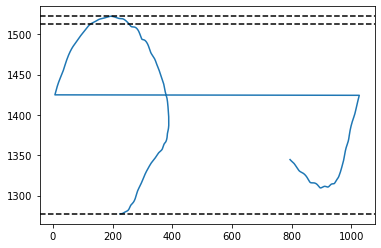

In [18]:
fig,ax  = plt.subplots()
ax.plot(flti.x,flti.y)
ax.axhline(y=latmax,c='k',linestyle='--')
ax.axhline(y=latmin,c='k',linestyle='--')
ax.axhline(y=latmid,c='k',linestyle='--')

In [35]:
eps = 0.05
flti.y[np.abs(flti.y-latmid)<eps].index

Float64Index([1551.5278, 1557.5], dtype='float64', name='time')

In [19]:
x, y, t = 10, 10, 6
ds = ds.chunk({'time': t, 'x_rho': x, 'x_u': x, 'y_rho': y, 'y_v': y})

In [20]:
ds = ds.persist()

In [21]:
ds

<xarray.Dataset>
Dimensions:       (time: 14400, x_rho: 52, x_u: 52, y_rho: 145, y_v: 145)
Coordinates:
    f_u           (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    s_rho_slice0  float32 -0.01
  * x_u           (x_u) float32 0.0 20000.0 40000.0 ... 1000000.0 1020000.0
  * x_rho         (x_rho) float32 -2000.0 18000.0 38000.0 ... 998000.0 1018000.0
  * time          (time) float64 dask.array<chunksize=(6,), meta=np.ndarray>
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 1.6e+03 1.6e+03
    f_v           (y_v) float32 dask.array<chunksize=(10,), meta=np.ndarray>
  * y_v           (y_v) float32 0.0 20000.0 40000.0 ... 2860000.0 2880000.0
    f_rho         (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
    x_v           (x_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
  * y_rho         (y_rho) float32 -2000.0 18000.0 ... 2858000.0 2878000.0
    y_u           (y_rho) float32 dask.array<chunksize=(10,), meta=np.ndarray>
Data variables:
    u             (time, y_rho, x_u) float32 dask.array<chunksize=(6, 10, 10), meta=np.ndarray>
    v             (time, y_v, x_rho) float32 dask.array<chunksize=(6, 10, 10), meta=np.ndarray>
Attributes:
    name:         surf
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2020-Feb-03 10:28:55 GMT
    uuid:         979d973b-3250-4199-96c2-7dff8e4f5076

In [22]:
ds['x_u'] = ds['x_u']/1000

In [23]:
ds['y_rho'] = ds['y_rho']/1000

In [24]:
ds = ds.chunk({'time':-1})

In [82]:
ds.u.time.values

array([1500.00694444, 1500.01388889, 1500.02083333, ..., 1599.98611111,
       1599.99305556, 1600.        ])

In [25]:
Time = flt1.loc[t0:t1].index
dsi = ds.u.sel(time=slice(1500,1600))

In [26]:
dsg = (ds.u.shift(time=1)+ds.u)/2

In [27]:
dst = dsg.sel(time=slice(t0-2/(12*24),t1))

In [28]:
ds_zoom = dst.sel(x_u = slice(flt1.x.loc[t0:t1].min()-40,flt1.x.loc[t0:t1].max()+40),
        y_rho = slice(flt1.y.loc[t0:t1].min()-40,flt1.y.loc[t0:t1].max()+40))

In [29]:
posmean = flt1[['x','y']].loc[tmid] 
xmean,ymean = [posmean.x,posmean.y]
xlim = [flt1['x'].loc[t0:t1].min(),flt1['x'].loc[t0:t1].max()]
x0,y0 = [flt1['x'].loc[t0],flt1['y'].loc[t0]]

In [101]:
flt1.y.max()

714.2809599999999

In [14]:
def distance(x,y,x0,y0):
    return np.sqrt((x-x0)**2+(y-y0)**2)

In [30]:
dsu = dst.sel(y_rho=ymean,x_u=xmean,method='nearest')

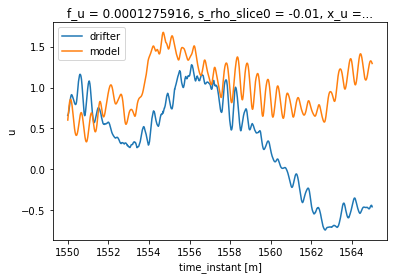

In [31]:
flt1.loc[t0:t1].u.plot(label='drifter')
dsu.plot(label='model')
plt.legend()

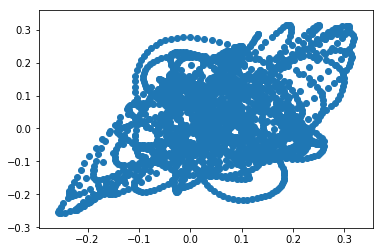

In [17]:
plt.scatter(flt1.loc[t0:t1].u,dsu)

(2161,)

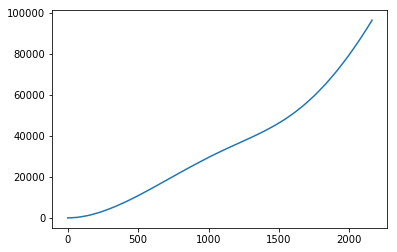

In [21]:
plt.plot(distance([x for x in flt1.xgrid.loc[t0:t1]*4],[y for y in flt1.ygrid.loc[t0:t1]*4],x0*4,y0*4).cumsum())
distance([x for x in flt1.xgrid.loc[t0:t1]*4],[y for y in flt1.ygrid.loc[t0:t1]*4],x0*4,y0*4).cumsum().shape

In [10]:
X,Y = [np.around(flt1.xgrid.loc[t0:t1]*4,decimals=0),flt1.ygrid.loc[t0:t1]*4]

In [27]:
dsu_time = dst.sel(time=tmid,method='nearest').compute()

In [26]:
dsu_space = dsu_time.sel(y_rho=flt1.loc[t0:t1].y.values,method='nearest').compute()

In [29]:
dsu_space = dus_space.sel(x_u=flt1.loc[t0:t1].x.values,method='nearest').compute()

In [32]:
DS=[]
for t in flt1.loc[t0:t1].index:
    DS.append(dsu_time.sel(y_rho=flt1.loc[t].y,x_u=flt1.loc[t].x,method='nearest').values)

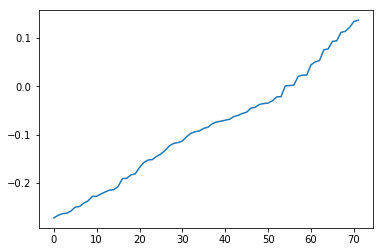

In [52]:
plt.plot(np.unique(DS))

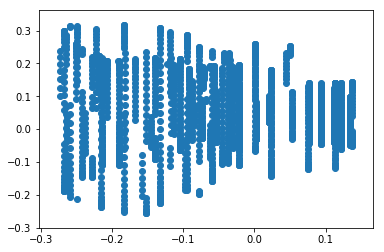

In [50]:
plt.scatter(DS,flt1.loc[t0:t1].u)

(Text(0.5, 0, '$x_{\\rho}$'), Text(0, 0.5, '$y_{\\rho}$'))

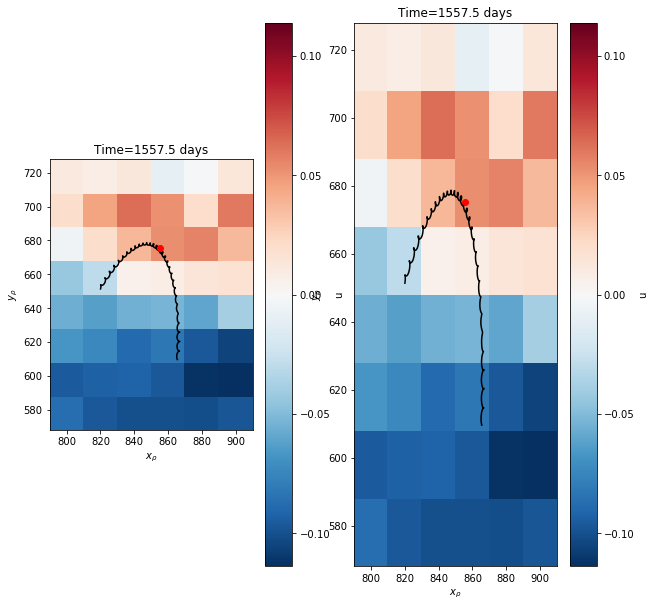

In [92]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1)
#Dsu.sel(x_u = slice(flt1.x.loc[t0:t1].min()-40,flt1.x.loc[t0:t1].max()+40),
#        y_rho = slice(flt1.y.loc[t0:t1].min()-40,flt1.y.loc[t0:t1].max()+40)).plot(ax=ax)
ds_zoom.sel(time=tmid,method='nearest').plot(ax=ax)
ax.plot(flt1.x.loc[t0:t1],flt1.y.loc[t0:t1],c='k')
ax.plot(flt1.x.loc[tmid],flt1.y.loc[tmid],marker='o',c='r')
ax.set_aspect('equal');ax.set_title('Time=%s days'%tmid)
ax.set_xlabel(r'$x_{\rho}$'),ax.set_ylabel(r'$y_{\rho}$')
ax = fig.add_subplot(1,2,2)
ds_zoom.sel(x_u = slice(flt1.x.loc[t0:t1].min()-40,flt1.x.loc[t0:t1].max()+40),
        y_rho = slice(flt1.y.loc[t0:t1].min()-40,flt1.y.loc[t0:t1].max()+40)).sel(time=tmid,method='nearest').plot(ax=ax)
ax.plot(flt1.x.loc[t0:t1],flt1.y.loc[t0:t1],c='k')
ax.plot(flt1.x.loc[tmid],flt1.y.loc[tmid],marker='o',c='r')
ax.set_title('Time=%s days'%tmid)
ax.set_xlabel(r'$x_{\rho}$'),ax.set_ylabel(r'$y_{\rho}$')

(Text(0.5,0,'$x_{\\rho}$'), Text(0,0.5,'$y_{\\rho}$'))

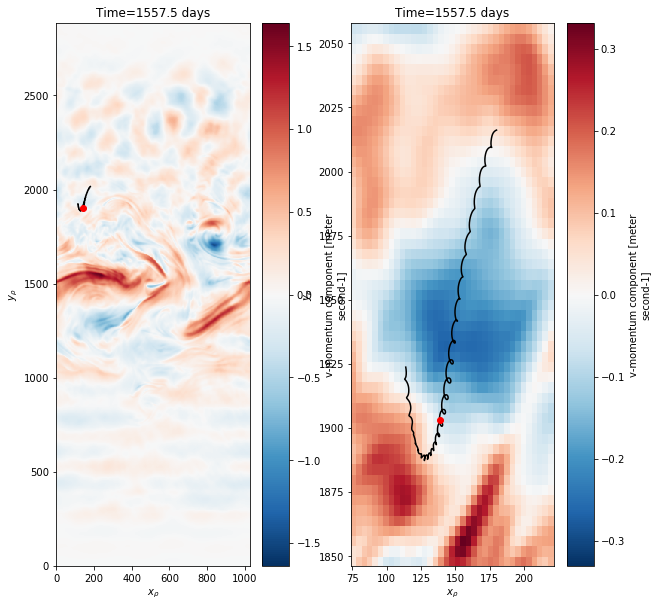

In [23]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1)
#Dsu.sel(x_u = slice(flt1.x.loc[t0:t1].min()-40,flt1.x.loc[t0:t1].max()+40),
#        y_rho = slice(flt1.y.loc[t0:t1].min()-40,flt1.y.loc[t0:t1].max()+40)).plot(ax=ax)
ds.u.sel(time=tmid,method='nearest').plot(ax=ax)
ax.plot(flt1.x.loc[t0:t1],flt1.y.loc[t0:t1],c='k')
ax.plot(flt1.x.loc[tmid],flt1.y.loc[tmid],marker='o',c='r')
ax.set_aspect('equal');ax.set_title('Time=%s days'%tmid)
ax.set_xlabel(r'$x_{\rho}$'),ax.set_ylabel(r'$y_{\rho}$')
ax = fig.add_subplot(1,2,2)
ds.u.sel(x_u = slice(flt1.x.loc[t0:t1].min()-40,flt1.x.loc[t0:t1].max()+40),
        y_rho = slice(flt1.y.loc[t0:t1].min()-40,flt1.y.loc[t0:t1].max()+40)).sel(time=tmid,method='nearest').plot(ax=ax)
ax.plot(flt1.x.loc[t0:t1],flt1.y.loc[t0:t1],c='k')
ax.plot(flt1.x.loc[tmid],flt1.y.loc[tmid],marker='o',c='r')
ax.set_title('Time=%s days'%tmid)
ax.set_xlabel(r'$x_{\rho}$'),ax.set_ylabel(r'$y_{\rho}$')

Text(0.5, 0.98, 'Time=1557.5 days')

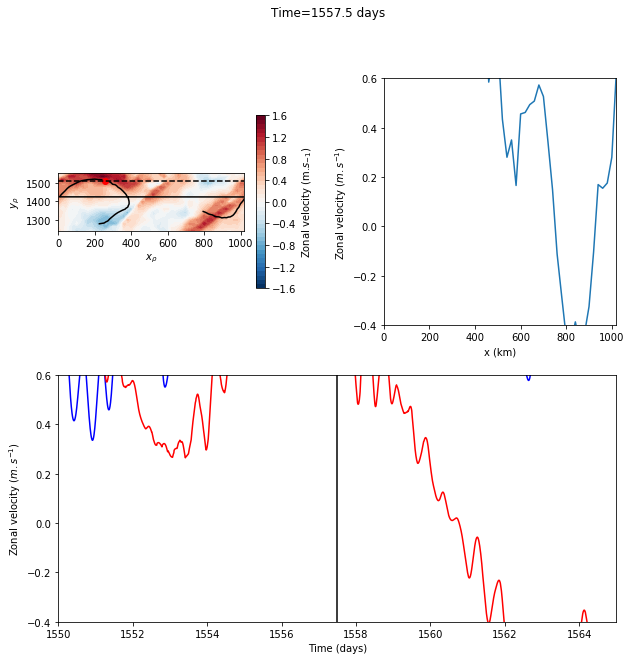

In [190]:
fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.2)
ax = plt.subplot(grid[0,0])
cs = ds_zoom.sel(time=tmid,method='nearest').plot.contourf(ax=ax,add_colorbar=False,levels=50)
plt.colorbar(cs,shrink=0.7,label=r'Zonal velocity (m.$s_{-1}$)')
#ax.plot(flt1.x.loc[t0:t1],flt1.y.loc[t0:t1],c='k',title=None)
flt1.loc[t0:t1].plot(x='x',y='y',ax=ax,kind='line',c='k',xlim=(ds_zoom.x_u.min(),ds_zoom.x_u.max()),title=None,legend=None)
ax.plot(flt1.x.loc[tmid],flt1.y.loc[tmid],marker='o',c='r')
ax.axhline(y=ymean,c='k',linestyle='--')
ax.set_aspect('equal')
ax.set_title('')
ax.set_xlabel(r'$x_{\rho}$'),ax.set_ylabel(r'$y_{\rho}$')
ax = plt.subplot(grid[0,1])
dst.sel(time = tmid,y_rho=ymean,method='nearest').plot(ax=ax,xlim=(ds_zoom.x_u.min(),ds_zoom.x_u.max()),ylim=(-0.4,0.6))
ax.set_xlabel('x (km)');ax.set_ylabel('Zonal velocity ($m.s^{-1})$')
ax.set_title('')
ax = plt.subplot(grid[1,:])
dst.sel(x_u=xmean,y_rho=ymean,method='nearest').plot(ax=ax,c='b',xlim=(t0,t1),ylim=(-0.4,0.6))
flt1[['u']].plot(ax=ax,c='r',xlim=(t0,t1),ylim=(-0.4,0.6),title=None,legend=None)
ax.axvline(x=tmid,c='k')
ax.set_xlabel('Time (days)');ax.set_ylabel('Zonal velocity ($m.s^{-1})$')
ax.set_title('')

fig.suptitle('Time=%s days'%tmid)

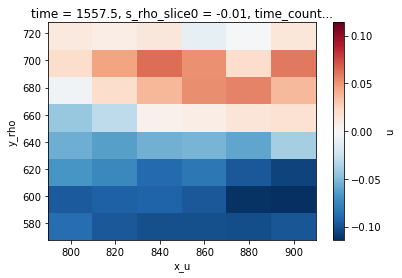

In [96]:
ds_zoom.sel(time=tmid,method='nearest').plot()

In [152]:
print('Time %s'%np.around(1550.00069,decimals=1))

Time 1550.0


In [32]:
def genfig(t,figsize,figdir, overwrite=True,offline=True):
    figname = figdir+'flt119_t%s' %(np.around(t, decimals=2))+'.png'
    if not os.path.isfile(figname) or overwrite:
        MPL_LOCK = threading.Lock()
        with MPL_LOCK:
            plt.switch_backend('agg')    
            fig = plt.figure(figsize=figsize)
            grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.2)
            ax = plt.subplot(grid[0,0])
            cs = ds_zoom.sel(time=t,method='nearest').plot.contourf(ax=ax,vmax = 1.6,vmin = -1.6,cmap = 'RdBu_r',add_colorbar=False,levels=50)
            plt.colorbar(cs,shrink=0.8,label=r'Zonal velocity (m.$s_{-1}$)')
            #ax.plot(flt1.x.loc[t0:t1],flt1.y.loc[t0:t1],c='k',title=None)
            flt1.loc[t0:t1].plot(x='x',y='y',ax=ax,kind='line',c='k',xlim=(ds_zoom.x_u.min(),ds_zoom.x_u.max()),title=None,legend=None)
            ax.plot(flt1.x.loc[t],flt1.y.loc[t],marker='o',c='r')
            ax.plot(xmean,ymean,c='b',marker='d')
            ax.axhline(y=ymean,c='k',linestyle='--')
            ax.set_aspect('equal')
            ax.set_title('')
            ax.set_xlabel(r'$x_{\rho}$'),ax.set_ylabel(r'$y_{\rho}$')
            ax = plt.subplot(grid[1,:])
            dst.sel(x_u=xmean,y_rho=ymean,method='nearest').plot(ax=ax,c='b',xlim=(t0,t1),ylim=(-1.4,1.7))
            flt1[['u']].plot(ax=ax,c='r',xlim=(t0,t1),ylim=(-1.4,1.7),title=None,legend=None)
            ax.axvline(x=t,c='k')
            ax.set_xlabel('Time (days)');ax.set_ylabel('Zonal velocity ($m.s^{-1})$')
            ax.set_title('')
            ax = plt.subplot(grid[0,1])
            dst.sel(time = t,y_rho=ymean,method='nearest').plot(ax=ax,xlim=(ds_zoom.x_u.min(),ds_zoom.x_u.max()),ylim=(-1.4,1.7))
            ax.set_xlabel('x (km)');ax.set_ylabel('Zonal velocity ($m.s^{-1})$')
            ax.set_title('')
            fig.suptitle('Time=%s days'%t)
            if offline:
                fig.savefig(figname)
                plt.close()
            m = 1.
    else:
        m = -1.
    return m

In [33]:
Time

Float64Index([   1550.0, 1550.0069, 1550.0139, 1550.0208, 1550.0278, 1550.0347,
              1550.0417, 1550.0486, 1550.0556, 1550.0625,
              ...
              1564.9375, 1564.9444, 1564.9514, 1564.9583, 1564.9653, 1564.9722,
              1564.9792, 1564.9861, 1564.9931,    1565.0],
             dtype='float64', name='time', length=2161)

In [ ]:
II = np.array_split(Time[::6],Time[::6].size/56)
II

In [41]:
figdir = '/home1/datahome/zcaspar/figs/'
#for t in Time[::6] : 
for I in II:
    print('  %d - %d'%(I[0],I[-1]))
    #print(t)
    values = [genfig(t,(10,10),figdir,overwrite=True,offline=True) for t in I]

  1550 - 1552
  1552 - 1555
  1555 - 1557
  1557 - 1560
  1560 - 1562
  1562 - 1565


In [ ]:
def genfig(i, ds, v, flt, n, size, overwrite=True, offline=True):
    
    figname = figdir+'float_%s_t%05d_%s' %(v, n, size)+'.png'
    
    if not os.path.isfile(figname) or overwrite:
        time = ds['time_instant'].values
        
        #
        MPL_LOCK = threading.Lock()
        with MPL_LOCK:
            plt.switch_backend('agg')    
            #
            flti = flt.loc[i]
            fig = plt.figure(figsize=(10,10))
            grid = plt.GridSpec(3, 1, wspace=0.4, hspace=0.3)
    
            ax = plt.subplot(grid[2, :])
    #off1 = .5
            ax.plot(flt.index,flt.u)
            ax.axvline(x=i, color='k', lw=1)
            ax.set_xlabel('Time (days)');ax.set_ylabel(r'Zonal velocity ($m.s^{-1}$)')
            ax = plt.subplot(grid[:2, :])    
            ax.plot(flt.x, flt.y)
   
            ax.plot(flti.x, flti.y, marker='d', ms=8, 
                    markeredgecolor='k')
            ds.plot.contourf(ax=ax, levels = np.linspace(-1,0,20), cmap='RdBu_r')
            ax.set_xlabel(r'$x_\rho$');ax.set_ylabel(r'$y_\rho$')
            ax.set_title(r'Time$\simeq$%sdays'%np.around(i,decimals=1))
            if offline:
                fig.savefig(figname)
                plt.close()
            #
            m = 1.
    else:
        m = -1.
    return m

In [47]:
del ds

In [ ]:
cluster.close()